# Neuroevolution Deliverable 2


Name | Student #
----- | -----
Adriana Monteiro | 20220604
Farina Pontejos | 20210649
Marta Dinis 	| 20220611
Patrícia Morais | 20220638
Samuel Santos | 20220609


## Project Description

1. Defining a string-based representation for the networks (the genotype).
2. Defining a network class that is able to parse those instructions and build a functional pytorch network structure (the phenotype). 
3. Defining a string-based representation for the optimizer. 
4. Defining a way to parse those instructions and build and functional pytorch optimizer. 
5. Sample all parameter values from a grammar (this allows for a restricted search space and removes the need to deal with invalid combinations). 
6. Define 4 simple genetic operators: 
    - Network crossover
    - Add layer mutation
    - Remove layer mutation
    - Change optimizer mutation


### Evaluation

- Defining the grammar: 2pt
- Generating a network genotype: 2pt
- Generating an optimizer genotype: 2pt
- Generating a network phenotype: 3pt
- Generating an optimizer phenotype: 3pt
- Ensuring the networks have between 1 and 50 layers: 1pt 
- Implementing the genetic operators: 5pt
- Following the described experimental setup: 2pt


## Setup

### Import dependencies

In [48]:
import re

In [49]:
from tqdm.notebook import trange, tqdm

In [50]:
import json # only for debug pretty printing :)

In [51]:
!pip install mlxtend==0.19.0 -q
import torch
import torch.nn as nn
import torch.optim as optim

import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets , transforms
from dataclasses import dataclass
import torchvision.transforms as T 
from mlxtend.plotting import plot_decision_regions
from tqdm import tqdm
%matplotlib inline

### Define some constants

In [52]:
RANDOM_STATE = 42
MIN_LAYER_NUM = 2
MAX_LAYER_NUM = 50
N_EPOCHS = 50
np.random.seed(RANDOM_STATE)


### Define utility functions

In [53]:
def is_error():
    print("Error")
    return



In [54]:
def is_int(i):
    """
    Checks if an input string is an integer
    """
    try:
        int(i)
    except:
        return False
    return float(i) == int(i)


## Defining the grammar

For Linear Layers: the `"n"` parameter specifies the possible valid values for `out_features`.

In [55]:
grammar = { 
    'Layers' : {
        'Linear' : {
            'n' : [1,2,3,4,5,6,7,8,9,10], 
            'bias' : [True, False]
        },
        'BatchNorm1d' : {
            'eps' : [1e-5, 1e-6, 1e-7], 
            'momentum' : [None, 0.1]
        },
        'LayerNorm' : {
            'eps' : [1e-3, 1e-4, 1e-5]
        },
        'Dropout' : {
            'p' : [0.3, 0.4, 0.5, 0.6, 0.7]
        },
        'AlphaDropout' : {
            'p' : [0.3, 0.4, 0.5, 0.6, 0.7]
        },
        'Activation' : {
            'function_name': ['Sigmoid', 
                'ReLU', 
                'PReLU', 
                'ELU', 
                'SELU', 
                'GELU', 
                'CELU', 
                'SiLU']
        }
    },
    'Optimizer' : { 
        'Adam' : {
            'lr' : [0.0001, 0.001, 0.01], 
            'betas' : [(0.9, 0.999), (.95, .99), (0.9, 0.99)]
        },
        'AdamW' : {
            'lr' : [0.0001, 0.001, 0.01], 
            'betas' : [(0.9, 0.999), (.95, .99), (0.9, 0.99)], 
            'weight_decay': [.01,.001,.0001 ]
        },
        'Adadelta' : {
            'lr' : [0.01, 0.1, 1], 
            'rho' : [0.9]
        },
        'NAdam' : {
            'lr' : [2e-3, 0.0001, 0.001, 0.01], 
            'betas' : [(0.9, 0.999), (.95, .99), (0.9, 0.99)], 
            'momentum_decay' : [4e-3]
        },
        'SGD' : {
            'lr' : [0.0001, 0.001, 0.01], 
            'momentum' : [0, .1, .2, .3, .4, .5, .6, .7, .8, .9], 
            'nesterov' : [True, False]
        }
    }
}

### Define valid options

Example of a valid input string:

```
(Layers{Linear{b:True}Activation{function_name:Sigmoid}Dropout{p:.5}})
(Optimizer{Adam{lr:0.01,betas:0.9}})
```

Top-level options are enclosed in parentheses `()`. Each top-level option begins with a string prefix defining itself, folowed by the configuration options specific to it, enclosed in curly braces `{}`.

The first option defines the layers in the network, denoted by the string prefix `Layers`. 

The second option defines the optimizer, denoted by the string prefix `Optimizer`.



The grammar below defines all the valid options for each configuration key.


### Define parsing functions

The `parse_...` functions below uses regular expressions to extract the different components of the dictionary from its string representation.

In [56]:
def recast(val):
    """
    From https://stackoverflow.com/questions/2859674/how-to-convert-list-of-strings-to-their-correct-python-types
    """
    constructors = [int, float, str]
    for c in constructors:
        try:
            # Handle bool special
            if (val == 'True') or (val == 'False'):
                return bool(val)
            else:
                return c(val)
        except ValueError:
            pass

def parse_args(args_list):
    
    args = [args_list]
    if "," in args_list:
        args = args_list.split(",")

    args_obj = {}
    
    for a in args:
        if ":" in a:
            args_obj[a.split(":")[0]] = recast(a.split(":")[1])
            return args_obj
        else: 
            return {args[0]:{}}

In [57]:
def parse_func(func_str, label):
    """
    Returns an object with shape:
    { function_name: {args:a} }
    """
    func_args = []
    func_patt = "(?P<funcname>([^\{]*))\{(?P<funcargs>([^\}]*))\}"
    r_patt = re.compile(func_patt)

    if (func_str.startswith("{}{{".format(label))) & (func_str.endswith("}")):
        
        func_def = func_str.removeprefix(label)[1:-1]
        func_list = [m.groupdict() for m in r_patt.finditer(func_def)]

        func_objlist = []
        for func in func_list:
            func_objlist.append({
                func['funcname']: parse_args(func['funcargs'])
                })
        return func_objlist
    else:
        is_error()
    return None
    

The function `recursive_valid` recursively visits all the dictionary keys and checks if each key exists as a valid key in the reference dictionary, and once at the leaf, checks if the value is valid.

In [58]:

def recursive_valid(test, valid, level=1, st=[]):

    primitives = ['str', 'int', 'float', 'bool']

    for k in test.keys():
        value_type = str(type(test[k]))

        if k not in valid.keys():
            print("Not a valid key:", k)
            break

        if ('list' in value_type) : 
            
            # value is a list, enter recursion
            for ti in test[k]:                
                for tik in ti.keys():
                    if tik in valid[k].keys():
                        if not recursive_valid({tik: ti[tik]}, 
                                               {tik: valid[k][tik]}, 
                                               level+1, 
                                               st+[k,ti,tik]):
                            print('invalid value found at:', st)
                            return False
                    else:
                        print(tik, 'not a valid key for', k)
                        return False


        elif ('dict' in value_type ) :  
            # value is a dictionary, enter recursion
            st.append(k)
            for vk in test[k].keys():
                if vk in valid[k].keys():
                    if not recursive_valid({vk: test[k][vk]}, 
                                       {vk: valid[k][vk]}, 
                                       level+1, 
                                       st+[k,vk]):
                        st.append(vk)
                        print('invalid value found at:', st)
                        return False
                else:
                    print('invalid key', vk, 'in', k )
                    return False




        elif any(subs in value_type for subs in primitives): 
            # value is a primitive 

            if test[k] in valid[k]:
                pass
            elif (test[k]=='in_features') or (test[k]=='out_features'):
                pass
            else:                
                print('invalid value for {}: {}'.format( k, test[k]))
                print('valid values are', valid[k])
                return False
        else:
            return False
            
    return True


The `parse_input` function converts the string representation into a Python dictionary, coercing the correct datatypes (int, str, bool, float, etc). It also checks the values for validity.

In [59]:
def parse_input(input_str):

    input_str = input_str.replace(" ","")

    config = {}

    input_rx = "\((?P<layers>[^\(]*)\)\((?P<optimizer>[^\(]*)\)"
    input_re = re.compile(input_rx)

    input_str = input_str.replace(" ", "")
    input_list = [m.groupdict() for m in input_re.finditer(input_str)][0]
    
    #######################
    ####### Parse Layers ##
    #######################
    input_layers = input_list['layers']

    layers_list = parse_func(input_layers, "Layers")
    
    config['Layers'] = layers_list

    ##########################
    ####### Parse Optimizer ##
    ##########################
    config['Optimizer'] = parse_func(input_list['optimizer'], "Optimizer")[0]

    #####################################
    ####### Check if options are valid ##
    #####################################

    if recursive_valid(config, grammar):
        print('Valid configuration options')
    else:
        print('Invalid configuration options')
        return

    ######################
    ####### Return dict ##
    ######################
    
    return config


In [60]:
test_inputstr = "(Layers{Linear{n:5, b:True}Activation{function_name:Sigmoid}Dropout{p:.5}})(Optimizer{Adam{lr:0.01,betas:0.9}})"
invalid_test = "(Layers{Linear{xn:5, b:True}Dropout{p:.5}}Activation{function_name:X})(Optimizer{Adam{lr:0.01,betas:10.9}})"

inputs = parse_input(test_inputstr)
print(json.dumps(inputs))
print("\n\nTest invalid option:")
parse_input(invalid_test)


Valid configuration options
{"Layers": [{"Linear": {"n": 5}}, {"Activation": {"function_name": "Sigmoid"}}, {"Dropout": {"p": 0.5}}], "Optimizer": {"Adam": {"lr": 0.01}}}


Test invalid option:
invalid key xn in Linear
invalid value found at: ['Optimizer']
Invalid configuration options


In [61]:
inputs


{'Layers': [{'Linear': {'n': 5}},
  {'Activation': {'function_name': 'Sigmoid'}},
  {'Dropout': {'p': 0.5}}],
 'Optimizer': {'Adam': {'lr': 0.01}}}

The `stringify_...` functions below turn a dictionary of configuration options into its string representation that can be parsed by the `parse_...` functions above.

In [62]:
def stringify_layers(layers):

    layers_list = []

    for layer in layers:
        for lk in layer.keys():
            lv = layer[lk]
            layer_args = []
            for lv_k in lv:
                layer_args.append("{}:{}".format(lv_k,lv[lv_k]))
            layers_list.append("{}{{{}}}".format(lk, ",".join(layer_args)))

    layers_str = "".join(["{}".format(i) for i in layers_list])
    return "(Layers{{{}}})".format(layers_str)

def stringify_optimizer(optimizer):
    o_args = []
    o_name = ""

    for o in optimizer:
        o_name = o
        opti = optimizer[o]

        for ok in opti:
            o_args.append("{}:{}".format(ok, opti[ok]))

    o_str = ",".join(["{}".format(i) for i in o_args])
    return "(Optimizer{{{}{{{}}}}})".format(o_name,o_str)

def stringify_activation(activation):
    return "(Activation{{{}}})".format(activation)

def stringify_dict(d):

    l = stringify_layers(d['Layers'])
    o = stringify_optimizer(d['Optimizer'])

    return "".join([l,o])
stringify_dict(inputs)

'(Layers{Linear{n:5}Activation{function_name:Sigmoid}Dropout{p:0.5}})(Optimizer{Adam{lr:0.01}})'

In [63]:
round_trip_inputstr = "(Layers{Linear{bias:True}Activation{function_name:Sigmoid}Dropout{p:0.5}})(Optimizer{Adam{lr:0.01}})"
parse_input(round_trip_inputstr)

Valid configuration options


{'Layers': [{'Linear': {'bias': True}},
  {'Activation': {'function_name': 'Sigmoid'}},
  {'Dropout': {'p': 0.5}}],
 'Optimizer': {'Adam': {'lr': 0.01}}}


Generator functions

## Generating a network genotype

In [64]:
np.random.seed(RANDOM_STATE)

DATA_IN_FEATURES = 28*28  # shape of input data
DATA_OUT_FEATURES = 10    # number of labels

FORCE_FIRST_LAYER = "Linear"
FORCE_LAST_LAYER = "Linear" 


def random_choice(a, s=None):
    # Do it like this because some params are a list of tuples
    # random.choice fails with list of tuples

    if 'tuple' in str(type(a[0])):
        rc = np.random.choice(len(a), size=s)
        c = a[rc]
    else:
        c = np.random.choice(a, size=s)

    return c

def random_ints(l,h,s=None):
    i = np.random.randint(low=l, high=h, size=s)
    return i

def enforce_layer_n(layers):
    if FORCE_FIRST_LAYER != None:
        layers[0] = FORCE_FIRST_LAYER
    if FORCE_LAST_LAYER != None:
        layers[-1] = FORCE_LAST_LAYER
    return layers



def enforce_in_out_feats(layers_list, last_out=DATA_OUT_FEATURES, grammar=grammar):
    """
    last_out = number of labels; used for last linear layer out_features
    
    """

    last_out_feats = None

    for li, lc in enumerate(layers_list):
        
        lcv = list(lc.values())[0]
        valid_out = grammar['Layers']['Linear']['n']

        current_layer_name = list(lc.keys())[0]

        if li == 0:
            if DATA_IN_FEATURES != None:
                # This part should take the data input shape
                layers_list[li][current_layer_name]['in_features'] = DATA_IN_FEATURES
            
            new_out = random_choice(valid_out)
            layers_list[li][current_layer_name]['out_features'] = new_out

            last_out_feats = lcv['out_features']
        elif li > 0 :
            # if not the first layer,
            # set in_feat equal to last_out_feats
            # but only if current layer is linear

            prev_layer_name = list(layers_list[li-1].keys())[0]

            if current_layer_name == "Linear":
                new_out = random_choice(valid_out)
                layers_list[li][current_layer_name]['in_features'] = last_out_feats
                layers_list[li][current_layer_name]['out_features'] = new_out
                last_out_feats = new_out

            elif (current_layer_name == "Dropout") \
                or (current_layer_name == "AlphaDropout") \
                or (current_layer_name == "BatchNorm1d"):
                layers_list[li][current_layer_name]['num_features'] = last_out_feats
            elif (current_layer_name == "LayerNorm"):
                layers_list[li][current_layer_name]['normalized_shape'] = (last_out_feats,)

        if li == (len(layers_list) - 1) :
            #  If last layer, make out_features == # labels
            layers_list[li][current_layer_name]['out_features'] = last_out

    return layers_list


def random_layers_generator(g, return_dict=True):
    """
    Returns a list of layers based on valid configuration options from input grammar g.
    return_dict=True returns a dictionary, or the string version otherwise.
    """

    n_layers = random_ints(MIN_LAYER_NUM,MAX_LAYER_NUM,None)
    
    layers_names = []
    layers_list = []

    valid_layers = list(g.keys())
    layer_indices = random_choice(range(len(valid_layers)), n_layers)
    layers_names = [valid_layers[i] for i in layer_indices]
    
    # Enforce layer positioning rules
    layers_names = enforce_layer_n(layers_names)


    for li, ln in enumerate(layers_names):
        # for each layer type selected
        layer_config = {}
        lk = list(g[ln].keys())
        for ki in lk: 
            # for each key in list of keys of layer config
            # make a random choice from valid options in g
            
            layer_config[ki] = random_choice(g[ln][ki])
        layers_list.append({ln:layer_config})
    
    # Enforce in_feats and out_feats on first and last layers
    layers_list = enforce_in_out_feats(layers_list, grammar=grammar)

    if return_dict :
        return layers_list
    else :
        return stringify_layers(layers_list)



In [65]:

test_linear = [{'Linear':{'in_features':784, 'out_features':5, 'bias':True}},
{'Linear':{'in_features':5, 'out_features':7, 'bias':False}},
{'Linear':{'in_features':5, 'out_features':10, 'bias':False}}
]

enforce_in_out_feats(test_linear, grammar=grammar)


[{'Linear': {'in_features': 784, 'out_features': 7, 'bias': True}},
 {'Linear': {'in_features': 7, 'out_features': 4, 'bias': False}},
 {'Linear': {'in_features': 4, 'out_features': 10, 'bias': False}}]

In [66]:
example_g = [
    {"Linear": {"in_features": 10, "out_features": 5, 'bias': True}},
    {'Dropout': {'p': 0.5}},
    {"Linear": {'bias': True}}
]

enforce_in_out_feats(example_g, grammar=grammar)

[{'Linear': {'in_features': 784, 'out_features': 5, 'bias': True}},
 {'Dropout': {'p': 0.5, 'num_features': 5}},
 {'Linear': {'bias': True, 'in_features': 5, 'out_features': 10}}]

## Generating an optimizer genotype

In [67]:
def random_optimizer_generator(g, return_dict=True):
    o_name = random_choice(list(g.keys()))
    o_config = {}
    for oi in g[o_name].keys():
        o_config[oi] = random_choice(g[o_name][oi])
    
    if o_name == 'SGD':
        if 'nesterov' in o_config.keys():
            if o_config['nesterov'] == True:
                o_config['momentum'] = random_choice(g['SGD']['momentum'][1:])

    o = {o_name:o_config}


    if return_dict:
        return o
    else:
        return stringify_optimizer(o)

## Ensure the networks have between 2 and 50 layers !!!!!!!!!!!

(See in generating_random_layers)

## Implementing the genetic operators

### Network crossover


In [68]:
def crossover(p1, p2):

  #generating random indexes
  ints_p1 = np.sort(random_choice(range(1,len(p1)-1), s=2))
  ints_p2 = np.sort(random_choice(range(1,len(p2)-1), s=2))

  # If one of the parents has no internal layers, we generate an empty slice
  if len(p1) > 2:
    #generating random indexes
    ints_p1 = np.sort(random_choice(range(1,len(p1)-1), s=2))
  else:
    # No internal layers to mutate
    ints_p1 = [2,2]

  if len(p2) > 2:
    ints_p2 = np.sort(random_choice(range(1,len(p2)-1), s=2))
  else:
    ints_p2 = [2,2]

  #generating offsprings
  o1 = p1.copy()
  o2 = p2.copy()

  #switching layers
  o1[ints_p1[0]:ints_p1[1]+1], o2[ints_p2[0]:ints_p2[1]+1] = p2[ints_p2[0]:ints_p2[1]+1], p1[ints_p1[0]:ints_p1[1]+1]

  #lenght of each chunk
  len_chunk_p1 = ints_p1[1]-ints_p1[0]+1
  len_chunk_p2 = ints_p2[1]-ints_p2[0]+1
  
  #adapting the number of neurons - input and output - of the remaining layers
  
  o1 = enforce_in_out_feats(o1, grammar=grammar)
  o2 = enforce_in_out_feats(o2, grammar=grammar)
  
  return o1, o2


In [69]:
grammar

{'Layers': {'Linear': {'n': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
   'bias': [True, False]},
  'BatchNorm1d': {'eps': [1e-05, 1e-06, 1e-07], 'momentum': [None, 0.1]},
  'LayerNorm': {'eps': [0.001, 0.0001, 1e-05]},
  'Dropout': {'p': [0.3, 0.4, 0.5, 0.6, 0.7]},
  'AlphaDropout': {'p': [0.3, 0.4, 0.5, 0.6, 0.7]},
  'Activation': {'function_name': ['Sigmoid',
    'ReLU',
    'PReLU',
    'ELU',
    'SELU',
    'GELU',
    'CELU',
    'SiLU']}},
 'Optimizer': {'Adam': {'lr': [0.0001, 0.001, 0.01],
   'betas': [(0.9, 0.999), (0.95, 0.99), (0.9, 0.99)]},
  'AdamW': {'lr': [0.0001, 0.001, 0.01],
   'betas': [(0.9, 0.999), (0.95, 0.99), (0.9, 0.99)],
   'weight_decay': [0.01, 0.001, 0.0001]},
  'Adadelta': {'lr': [0.01, 0.1, 1], 'rho': [0.9]},
  'NAdam': {'lr': [0.002, 0.0001, 0.001, 0.01],
   'betas': [(0.9, 0.999), (0.95, 0.99), (0.9, 0.99)],
   'momentum_decay': [0.004]},
  'SGD': {'lr': [0.0001, 0.001, 0.01],
   'momentum': [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
   'nesterov': [True

### Add layer mutation


Add layer - check if we're already at the maximum number of layers

In [70]:
def add_layer_mut(ind, grammar):
  
  #generating random index
  index = int(random_ints(1,len(ind), s=1))

  #generating a new layer
  
  new_layer_name = random_choice(list(grammar['Layers'].keys()))
  new_layer_conf = {}

  new_layer_conf = {}
  new_layer_keys = list(grammar['Layers'][new_layer_name].keys())

  for k in new_layer_keys:

    new_layer_opts = grammar['Layers'][new_layer_name][k]
    new_layer_conf[k] = random_choice(new_layer_opts)


  new_layer = {new_layer_name: new_layer_conf}

  #add layer
  mut_ind = ind.copy()
  mut_ind.insert(index,new_layer)

  
  #adapting the number of neurons - input and output - of the remaining layers
  mut_ind = enforce_in_out_feats(mut_ind, grammar=grammar)


  return mut_ind

### Remove layer mutation


In [71]:
def remove_layer_mut(ind):

  mut_ind = ind.copy()

  # if there are hidden layers, we can perform remove layer mutation
  if len(ind) > 2:

    #generating random index
    index = int(random_ints(1,len(ind)-1, s=1))

    #remove layer
    mut_ind.pop(index)

    #adapting the number of neurons - input and output - of the remaining layers
    mut_ind = enforce_in_out_feats(mut_ind, grammar=grammar)

  return mut_ind

### Change optimizer mutation 

We implemented this as generating a new optimizer configuration.

## Generating a network phenotype

In [72]:
class Net(nn.Module):
    layers_list = None
    optimizer = None

    def __init__(self, 
                 layers_list, 
                #  optim_config
                 ):
        super(Net, self).__init__()


        self.layers = nn.ModuleList()
        self.layers_list = layers_list

        for layer_ in self.layers_list:
            layer = self.parse_layer_config(layer_)
            self.layers.append(layer)
        
        # Add a softmax layer after this step; 
        #self.layers.append( nn.Softmax(dim=10))
        self.layers.append( nn.Softmax(dim=1))

        self.flat = nn.Flatten()

    def parse_string(self):
      raise Exception("You need to monkeypatch the parse_string function")

    def forward(self, x):
        x=self.flat(x)
        for layer in self.layers:
            x = layer(x)
        return x
    

    def parse_layer_config(self, layer):
      layer_name = list(layer.keys())[0] 
      
      if layer_name == 'Linear':

        layer_args = layer[layer_name]
        if 'n' in layer_args.keys():
            layer_args.pop('n')
        return nn.Linear(**layer_args)

      elif layer_name == 'BatchNorm1d':
        layer_args = layer[layer_name]
        num_features = 0
        if 'num_features' in layer_args.keys():
            num_features = layer_args['num_features']
            layer_args.pop('num_features')

        return nn.BatchNorm1d(num_features,**layer_args)

      elif layer_name == 'LayerNorm':
        layer_args = layer[layer_name]
        return nn.LayerNorm(**layer_args)

      elif layer_name == 'Dropout':
        layer_args = layer[layer_name]
        num_features = 0
        if 'num_features' in layer_args.keys():
            num_features = layer_args['num_features']
            layer_args.pop('num_features')
        return nn.Dropout(**layer_args)

      elif layer_name == 'AlphaDropout':
        layer_args = layer[layer_name]
        num_features = 0
        if 'num_features' in layer_args.keys():
            num_features = layer_args['num_features']
            layer_args.pop('num_features','num_features')

        return nn.AlphaDropout(**layer_args)

      elif layer_name == 'Activation':
        layer_args = layer[layer_name]
        act = getattr(nn, layer_args["function_name"])

        return act()


      else:
        print(0,'----',layer_name)
        raise ValueError('Invalid layer config: {}\n{}'.format(layer_name, self.layers_list))


## Generating an optimizer phenotype

In [73]:
def make_optimizer(optim_config, model):

    o_name = list(optim_config.keys())[0]
    o_args = optim_config[o_name]
    o = getattr(optim, o_name)
    return o(model.parameters(), **o_args)


## Following the described experimental setup

In [74]:
device = torch.device('cuda')

batch_size = 32

train_dataset = datasets.MNIST('./data', 
                               train=True, 
                               download=True, 
                               transform=transforms.ToTensor())

validation_dataset = datasets.MNIST('./data', 
                                    train=False, 
                                    transform=transforms.ToTensor())

train_loader = DataLoader(dataset=train_dataset, 
                            batch_size=batch_size, 
                            shuffle=True)

validation_loader = DataLoader(dataset=validation_dataset, 
                                batch_size=batch_size, 
                                shuffle=False)

input_size = 28*28
output_size =  10


def run_training(model, optimizer, num_epochs=N_EPOCHS):
    # Define the loss function, we will use the standard Binary Crossentropy
    loss_fn = nn.CrossEntropyLoss()
    accs = []
    losses = []
    etqbar = trange(num_epochs, position=1, desc="Epoch: ", leave=False, colour='blue')
    for epoch in etqbar:
        accuracy_hist_train = 0
        for x_batch, y_batch in train_loader:
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)
            pred = model(x_batch)
            loss = loss_fn(pred, y_batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            is_correct = (torch.argmax(pred, dim=1) == y_batch).float()
            accuracy_hist_train += is_correct.sum()
        accuracy_hist_train /= len(train_loader.dataset)
        print(f'Epoch {epoch}  Accuracy {accuracy_hist_train:.4f}  Loss {loss:.4f}')
        accs.append(accuracy_hist_train)
        losses.append(loss)
        
    return (accs,losses)


### Generate 5 random networks

In [75]:
def generate_network(layers=None, optim=None, m=None):
    
    if layers==None:
    
        layers = random_layers_generator(grammar['Layers'])
    
    if m == None:
        model = Net(layers).to(device)
    else:
        model = m

    if optim==None:
        optim = random_optimizer_generator(grammar['Optimizer'])
    
    optimizer = make_optimizer(optim, model)
    

    
    conf = {'Layers':layers, 'Optimizer':optim}

    return conf, model, optimizer



In [76]:
conf1, net1, opt1 = generate_network()
conf2, net2, opt2 = generate_network()
conf3, net3, opt3 = generate_network()
conf4, net4, opt4 = generate_network()
conf5, net5, opt5 = generate_network()


In [77]:
print(conf1, conf2, conf3, conf4, conf5)

{'Layers': [{'Linear': {'bias': True, 'in_features': 784, 'out_features': 10}}, {'LayerNorm': {'eps': 1e-05, 'normalized_shape': (10,)}}, {'AlphaDropout': {'p': 0.5}}, {'Dropout': {'p': 0.4}}, {'LayerNorm': {'eps': 1e-05, 'normalized_shape': (10,)}}, {'Activation': {'function_name': 'GELU'}}, {'AlphaDropout': {'p': 0.5}}, {'BatchNorm1d': {'eps': 1e-07, 'momentum': 0.1}}, {'Dropout': {'p': 0.3}}, {'Activation': {'function_name': 'PReLU'}}, {'Activation': {'function_name': 'SELU'}}, {'BatchNorm1d': {'eps': 1e-07, 'momentum': None}}, {'Dropout': {'p': 0.7}}, {'AlphaDropout': {'p': 0.3}}, {'Linear': {'bias': False, 'in_features': 10, 'out_features': 5}}, {'Dropout': {'p': 0.6}}, {'BatchNorm1d': {'eps': 1e-05, 'momentum': 0.1}}, {'Activation': {'function_name': 'GELU'}}, {'AlphaDropout': {'p': 0.4}}, {'Linear': {'bias': True, 'in_features': 5, 'out_features': 10}}], 'Optimizer': {'NAdam': {'lr': 0.01, 'betas': (0.9, 0.99), 'momentum_decay': 0.004}}} {'Layers': [{'Linear': {'bias': False, 'i

In [78]:
random_nets = [(net1, opt1),
               (net2, opt2),
               (net3, opt3),
               (net4, opt4),
               (net5, opt5),
               ]

### Train the 5 random networks

In [79]:
metrics = {
    'Accuracy': [],
    'Loss': [],
    'Labels': []
}


tqbar = trange(len(random_nets), desc="Network: ", position=0)

for i in tqbar:
    n = random_nets[i]
    print("======================================================")
    print("Training random network #{}".format(i+1))
    print(n[0])
    mi = run_training(n[0], n[1]) 
    metrics['Accuracy'].append(mi[0])
    metrics['Loss'].append(mi[1])
    metrics['Labels'].append("Random {}".format(i+1))
    print("======================================================")
    tqbar.set_description("Network #{}".format(i+1))
    tqbar.update()


Network:   0%|          | 0/5 [00:00<?, ?it/s]

Training random network #1
Net(
  (layers): ModuleList(
    (0): Linear(in_features=784, out_features=10, bias=True)
    (1): LayerNorm((10,), eps=1e-05, elementwise_affine=True)
    (2): AlphaDropout(p=0.5, inplace=False)
    (3): Dropout(p=0.4, inplace=False)
    (4): LayerNorm((10,), eps=1e-05, elementwise_affine=True)
    (5): GELU(approximate='none')
    (6): AlphaDropout(p=0.5, inplace=False)
    (7): BatchNorm1d(10, eps=1e-07, momentum=0.1, affine=True, track_running_stats=True)
    (8): Dropout(p=0.3, inplace=False)
    (9): PReLU(num_parameters=1)
    (10): SELU()
    (11): BatchNorm1d(10, eps=1e-07, momentum=None, affine=True, track_running_stats=True)
    (12): Dropout(p=0.7, inplace=False)
    (13): AlphaDropout(p=0.3, inplace=False)
    (14): Linear(in_features=10, out_features=5, bias=False)
    (15): Dropout(p=0.6, inplace=False)
    (16): BatchNorm1d(5, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (17): GELU(approximate='none')
    (18): AlphaDrop

Epoch:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 0  Accuracy 0.1088  Loss 2.3001
Epoch 1  Accuracy 0.1091  Loss 2.3144
Epoch 2  Accuracy 0.1107  Loss 2.3047
Epoch 3  Accuracy 0.1103  Loss 2.2819
Epoch 4  Accuracy 0.1101  Loss 2.2949
Epoch 5  Accuracy 0.1109  Loss 2.2812
Epoch 6  Accuracy 0.1116  Loss 2.2985
Epoch 7  Accuracy 0.1134  Loss 2.2935
Epoch 8  Accuracy 0.1135  Loss 2.2898
Epoch 9  Accuracy 0.1137  Loss 2.3083
Epoch 10  Accuracy 0.1152  Loss 2.3119
Epoch 11  Accuracy 0.1167  Loss 2.2826
Epoch 12  Accuracy 0.1169  Loss 2.2880
Epoch 13  Accuracy 0.1178  Loss 2.2504
Epoch 14  Accuracy 0.1177  Loss 2.2952
Epoch 15  Accuracy 0.1162  Loss 2.3119
Epoch 16  Accuracy 0.1180  Loss 2.2856
Epoch 17  Accuracy 0.1164  Loss 2.3074
Epoch 18  Accuracy 0.1180  Loss 2.2926
Epoch 19  Accuracy 0.1184  Loss 2.3203
Epoch 20  Accuracy 0.1152  Loss 2.2672
Epoch 21  Accuracy 0.1181  Loss 2.3205
Epoch 22  Accuracy 0.1174  Loss 2.2779
Epoch 23  Accuracy 0.1175  Loss 2.3040
Epoch 24  Accuracy 0.1180  Loss 2.3133
Epoch 25  Accuracy 0.1175  Loss 2.2

Epoch:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 0  Accuracy 0.1018  Loss 2.3145
Epoch 1  Accuracy 0.1027  Loss 2.3001
Epoch 2  Accuracy 0.1039  Loss 2.3008
Epoch 3  Accuracy 0.1037  Loss 2.2887
Epoch 4  Accuracy 0.1035  Loss 2.2829
Epoch 5  Accuracy 0.1070  Loss 2.3190
Epoch 6  Accuracy 0.1093  Loss 2.3035
Epoch 7  Accuracy 0.1099  Loss 2.2820
Epoch 8  Accuracy 0.1116  Loss 2.3018
Epoch 9  Accuracy 0.1112  Loss 2.3113
Epoch 10  Accuracy 0.1125  Loss 2.3067
Epoch 11  Accuracy 0.1177  Loss 2.2939
Epoch 12  Accuracy 0.1167  Loss 2.3097
Epoch 13  Accuracy 0.1181  Loss 2.3156
Epoch 14  Accuracy 0.1172  Loss 2.3054
Epoch 15  Accuracy 0.1219  Loss 2.2912
Epoch 16  Accuracy 0.1215  Loss 2.3041
Epoch 17  Accuracy 0.1258  Loss 2.2935
Epoch 18  Accuracy 0.1279  Loss 2.3028
Epoch 19  Accuracy 0.1259  Loss 2.2855
Epoch 20  Accuracy 0.1289  Loss 2.2879
Epoch 21  Accuracy 0.1289  Loss 2.2794
Epoch 22  Accuracy 0.1310  Loss 2.3060
Epoch 23  Accuracy 0.1309  Loss 2.2893
Epoch 24  Accuracy 0.1360  Loss 2.2918
Epoch 25  Accuracy 0.1363  Loss 2.2

Epoch:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 0  Accuracy 0.1072  Loss 2.2948
Epoch 1  Accuracy 0.1121  Loss 2.3072
Epoch 2  Accuracy 0.1121  Loss 2.3044
Epoch 3  Accuracy 0.1142  Loss 2.3078
Epoch 4  Accuracy 0.1148  Loss 2.2988
Epoch 5  Accuracy 0.1156  Loss 2.2750
Epoch 6  Accuracy 0.1159  Loss 2.2901
Epoch 7  Accuracy 0.1183  Loss 2.3062
Epoch 8  Accuracy 0.1172  Loss 2.2722
Epoch 9  Accuracy 0.1165  Loss 2.3088
Epoch 10  Accuracy 0.1165  Loss 2.2702
Epoch 11  Accuracy 0.1178  Loss 2.2601
Epoch 12  Accuracy 0.1182  Loss 2.2826
Epoch 13  Accuracy 0.1172  Loss 2.2928
Epoch 14  Accuracy 0.1168  Loss 2.2889
Epoch 15  Accuracy 0.1179  Loss 2.3081
Epoch 16  Accuracy 0.1187  Loss 2.2916
Epoch 17  Accuracy 0.1169  Loss 2.3066
Epoch 18  Accuracy 0.1177  Loss 2.3167
Epoch 19  Accuracy 0.1181  Loss 2.2737
Epoch 20  Accuracy 0.1181  Loss 2.2749
Epoch 21  Accuracy 0.1192  Loss 2.2764
Epoch 22  Accuracy 0.1177  Loss 2.2973
Epoch 23  Accuracy 0.1189  Loss 2.2713
Epoch 24  Accuracy 0.1174  Loss 2.2823
Epoch 25  Accuracy 0.1182  Loss 2.3

Epoch:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 0  Accuracy 0.1062  Loss 2.3077
Epoch 1  Accuracy 0.1089  Loss 2.2987
Epoch 2  Accuracy 0.1083  Loss 2.2877
Epoch 3  Accuracy 0.1084  Loss 2.3027
Epoch 4  Accuracy 0.1094  Loss 2.2935
Epoch 5  Accuracy 0.1077  Loss 2.3100
Epoch 6  Accuracy 0.1086  Loss 2.2896
Epoch 7  Accuracy 0.1082  Loss 2.3111
Epoch 8  Accuracy 0.1099  Loss 2.2942
Epoch 9  Accuracy 0.1097  Loss 2.3029
Epoch 10  Accuracy 0.1087  Loss 2.2862
Epoch 11  Accuracy 0.1080  Loss 2.2805
Epoch 12  Accuracy 0.1081  Loss 2.3281
Epoch 13  Accuracy 0.1097  Loss 2.2985
Epoch 14  Accuracy 0.1077  Loss 2.2975
Epoch 15  Accuracy 0.1090  Loss 2.2883
Epoch 16  Accuracy 0.1092  Loss 2.2980
Epoch 17  Accuracy 0.1095  Loss 2.3039
Epoch 18  Accuracy 0.1084  Loss 2.3166
Epoch 19  Accuracy 0.1091  Loss 2.3220
Epoch 20  Accuracy 0.1102  Loss 2.2921
Epoch 21  Accuracy 0.1084  Loss 2.3016
Epoch 22  Accuracy 0.1083  Loss 2.3105
Epoch 23  Accuracy 0.1092  Loss 2.3086
Epoch 24  Accuracy 0.1098  Loss 2.3268
Epoch 25  Accuracy 0.1083  Loss 2.3

Epoch:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 0  Accuracy 0.1072  Loss 2.3025
Epoch 1  Accuracy 0.1063  Loss 2.3014
Epoch 2  Accuracy 0.1078  Loss 2.2947
Epoch 3  Accuracy 0.1076  Loss 2.2965
Epoch 4  Accuracy 0.1067  Loss 2.2998
Epoch 5  Accuracy 0.1065  Loss 2.2998
Epoch 6  Accuracy 0.1068  Loss 2.3064
Epoch 7  Accuracy 0.1068  Loss 2.3060
Epoch 8  Accuracy 0.1073  Loss 2.3028
Epoch 9  Accuracy 0.1078  Loss 2.2987
Epoch 10  Accuracy 0.1076  Loss 2.3027
Epoch 11  Accuracy 0.1075  Loss 2.2960
Epoch 12  Accuracy 0.1066  Loss 2.2925
Epoch 13  Accuracy 0.1067  Loss 2.2997
Epoch 14  Accuracy 0.1063  Loss 2.2955
Epoch 15  Accuracy 0.1072  Loss 2.2908
Epoch 16  Accuracy 0.1077  Loss 2.3053
Epoch 17  Accuracy 0.1079  Loss 2.2918
Epoch 18  Accuracy 0.1058  Loss 2.3063
Epoch 19  Accuracy 0.1073  Loss 2.3014
Epoch 20  Accuracy 0.1073  Loss 2.3109
Epoch 21  Accuracy 0.1074  Loss 2.3131
Epoch 22  Accuracy 0.1054  Loss 2.3065
Epoch 23  Accuracy 0.1062  Loss 2.3064
Epoch 24  Accuracy 0.1075  Loss 2.3078
Epoch 25  Accuracy 0.1073  Loss 2.3

### Mutate the networks

#### Apply Crossover

In [80]:
mutl1, mutl2 = crossover(conf1['Layers'], conf2['Layers'])

mutconf1, mutnet1, mutopt1 = generate_network(mutl1, conf1['Optimizer'])
mutconf2, mutnet2, mutopt2 = generate_network(mutl2, conf2['Optimizer'])



#### Apply Add Layer mutation

In [81]:
conf3['Layers']

[{'Linear': {'bias': True, 'in_features': 784, 'out_features': 7}},
 {'Linear': {'bias': False, 'in_features': 7, 'out_features': 3}},
 {'Dropout': {'p': 0.4}},
 {'Dropout': {'p': 0.3}},
 {'Dropout': {'p': 0.7}},
 {'AlphaDropout': {'p': 0.5}},
 {'Linear': {'bias': False, 'in_features': 3, 'out_features': 6}},
 {'AlphaDropout': {'p': 0.5}},
 {'AlphaDropout': {'p': 0.5}},
 {'Linear': {'bias': True, 'in_features': 6, 'out_features': 2}},
 {'Linear': {'bias': True, 'in_features': 2, 'out_features': 10}},
 {'Linear': {'bias': True, 'in_features': 10, 'out_features': 9}},
 {'Linear': {'bias': False, 'in_features': 9, 'out_features': 5}},
 {'Dropout': {'p': 0.5}},
 {'LayerNorm': {'eps': 0.001, 'normalized_shape': (5,)}},
 {'LayerNorm': {'eps': 1e-05, 'normalized_shape': (5,)}},
 {'Linear': {'bias': False, 'in_features': 5, 'out_features': 6}},
 {'LayerNorm': {'eps': 0.001, 'normalized_shape': (6,)}},
 {'LayerNorm': {'eps': 1e-05, 'normalized_shape': (6,)}},
 {'Linear': {'bias': True, 'in_feat

In [82]:
mutl3 = add_layer_mut(conf3['Layers'], grammar)

mutconf3, mutnet3, mutopt3 = generate_network(mutl3, conf3['Optimizer'])


#### Apply Remove Layer mutation

In [83]:
mutl4 = remove_layer_mut(conf4['Layers'])
mutconf4, mutnet4, mutopt4 = generate_network(mutl4, conf4['Optimizer'])


#### Apply Change Optimizer mutation

In [84]:
mutl5 = conf5['Layers'].copy()
mutconf5, mutnet5, mutopt5 = generate_network(mutl5, m=net5)


In [85]:
mutconf5

{'Layers': [{'Linear': {'bias': False,
    'in_features': 784,
    'out_features': 10}},
  {'Dropout': {'p': 0.6}},
  {'Dropout': {'p': 0.5}},
  {'Linear': {'bias': False, 'in_features': 10, 'out_features': 1}},
  {'BatchNorm1d': {'eps': 1e-07, 'momentum': 0.1}},
  {'Linear': {'bias': False, 'in_features': 1, 'out_features': 8}},
  {'Activation': {'function_name': 'SELU'}},
  {'Dropout': {'p': 0.5}},
  {'AlphaDropout': {'p': 0.5}},
  {'AlphaDropout': {'p': 0.5}},
  {'LayerNorm': {'eps': 0.0001, 'normalized_shape': (8,)}},
  {'Linear': {'bias': False, 'in_features': 8, 'out_features': 1}},
  {'Linear': {'bias': False, 'in_features': 1, 'out_features': 9}},
  {'LayerNorm': {'eps': 1e-05, 'normalized_shape': (9,)}},
  {'LayerNorm': {'eps': 0.001, 'normalized_shape': (9,)}},
  {'LayerNorm': {'eps': 0.001, 'normalized_shape': (9,)}},
  {'Dropout': {'p': 0.6}},
  {'Activation': {'function_name': 'SELU'}},
  {'Linear': {'bias': False, 'in_features': 9, 'out_features': 6}},
  {'Dropout': {'p':

### Train mutated networks

In [86]:
mutated_nets = [
    (mutnet1, mutopt1, "Crossover1"),
    (mutnet2, mutopt2, "Crossover2"),
    (mutnet3, mutopt3, "Add Layer"),
    (mutnet4, mutopt4, "Remove Layer"),
    (mutnet5, mutopt5, "Change Optimizer")
]


In [87]:
metrics_mutated = {
    'Accuracy': [],
    'Loss': [],
    'Labels': []
}


tqbar = trange(len(mutated_nets), desc="Network: ", position=0)

for i in tqbar:
    n = mutated_nets[i]

    print("======================================================")
    print("Training mutated network: {}".format(n[2]))
    print(n[0])
    mi = run_training(n[0], n[1]) 
    metrics_mutated['Accuracy'].append(mi[0])
    metrics_mutated['Loss'].append(mi[1])
    metrics_mutated['Labels'].append(n[2])
    print("======================================================")
    tqbar.set_description("Network #{}".format(i+1))
    tqbar.update()


Network:   0%|          | 0/5 [00:00<?, ?it/s]

Training mutated network: Crossover1
Net(
  (layers): ModuleList(
    (0): Linear(in_features=784, out_features=2, bias=True)
    (1): LayerNorm((2,), eps=1e-05, elementwise_affine=True)
    (2): AlphaDropout(p=0.5, inplace=False)
    (3): Dropout(p=0.4, inplace=False)
    (4): LayerNorm((2,), eps=1e-05, elementwise_affine=True)
    (5): GELU(approximate='none')
    (6): AlphaDropout(p=0.5, inplace=False)
    (7): BatchNorm1d(2, eps=1e-07, momentum=0.1, affine=True, track_running_stats=True)
    (8): Dropout(p=0.3, inplace=False)
    (9): PReLU(num_parameters=1)
    (10): SELU()
    (11): BatchNorm1d(2, eps=1e-07, momentum=None, affine=True, track_running_stats=True)
    (12): LayerNorm((2,), eps=0.0001, elementwise_affine=True)
    (13): SELU()
    (14): Linear(in_features=2, out_features=7, bias=False)
    (15): BatchNorm1d(7, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (16): GELU(approximate='none')
    (17): AlphaDropout(p=0.4, inplace=False)
    (18): Linea

Epoch:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 0  Accuracy 0.1066  Loss 2.3036
Epoch 1  Accuracy 0.1096  Loss 2.3169
Epoch 2  Accuracy 0.1080  Loss 2.2826
Epoch 3  Accuracy 0.1100  Loss 2.3102
Epoch 4  Accuracy 0.1088  Loss 2.2992
Epoch 5  Accuracy 0.1091  Loss 2.3142
Epoch 6  Accuracy 0.1076  Loss 2.2960
Epoch 7  Accuracy 0.1099  Loss 2.2923
Epoch 8  Accuracy 0.1101  Loss 2.2831
Epoch 9  Accuracy 0.1095  Loss 2.3052
Epoch 10  Accuracy 0.1094  Loss 2.2989
Epoch 11  Accuracy 0.1084  Loss 2.3116
Epoch 12  Accuracy 0.1085  Loss 2.2956
Epoch 13  Accuracy 0.1095  Loss 2.2896
Epoch 14  Accuracy 0.1085  Loss 2.3090
Epoch 15  Accuracy 0.1093  Loss 2.2943
Epoch 16  Accuracy 0.1105  Loss 2.3111
Epoch 17  Accuracy 0.1090  Loss 2.2843
Epoch 18  Accuracy 0.1094  Loss 2.3096
Epoch 19  Accuracy 0.1096  Loss 2.3101
Epoch 20  Accuracy 0.1090  Loss 2.3109
Epoch 21  Accuracy 0.1093  Loss 2.3052
Epoch 22  Accuracy 0.1097  Loss 2.3015
Epoch 23  Accuracy 0.1095  Loss 2.2780
Epoch 24  Accuracy 0.1105  Loss 2.3163
Epoch 25  Accuracy 0.1095  Loss 2.3

Epoch:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 0  Accuracy 0.0988  Loss 2.3241
Epoch 1  Accuracy 0.0984  Loss 2.3026
Epoch 2  Accuracy 0.0990  Loss 2.3084
Epoch 3  Accuracy 0.1003  Loss 2.3069
Epoch 4  Accuracy 0.1008  Loss 2.2889
Epoch 5  Accuracy 0.0994  Loss 2.3145
Epoch 6  Accuracy 0.0989  Loss 2.2964
Epoch 7  Accuracy 0.0986  Loss 2.2991
Epoch 8  Accuracy 0.0991  Loss 2.3073
Epoch 9  Accuracy 0.0994  Loss 2.2809
Epoch 10  Accuracy 0.0971  Loss 2.2973
Epoch 11  Accuracy 0.0989  Loss 2.3001
Epoch 12  Accuracy 0.0982  Loss 2.3078
Epoch 13  Accuracy 0.0977  Loss 2.3117
Epoch 14  Accuracy 0.0995  Loss 2.3042
Epoch 15  Accuracy 0.1002  Loss 2.3127
Epoch 16  Accuracy 0.1008  Loss 2.3138
Epoch 17  Accuracy 0.1004  Loss 2.3040
Epoch 18  Accuracy 0.1011  Loss 2.3128
Epoch 19  Accuracy 0.1020  Loss 2.3078
Epoch 20  Accuracy 0.0991  Loss 2.3034
Epoch 21  Accuracy 0.1012  Loss 2.2911
Epoch 22  Accuracy 0.1013  Loss 2.3169
Epoch 23  Accuracy 0.1004  Loss 2.3185
Epoch 24  Accuracy 0.0998  Loss 2.2964
Epoch 25  Accuracy 0.1002  Loss 2.3

Epoch:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 0  Accuracy 0.1078  Loss 2.2950
Epoch 1  Accuracy 0.1123  Loss 2.2934
Epoch 2  Accuracy 0.1124  Loss 2.3120
Epoch 3  Accuracy 0.1124  Loss 2.2933
Epoch 4  Accuracy 0.1124  Loss 2.2924
Epoch 5  Accuracy 0.1123  Loss 2.2927
Epoch 6  Accuracy 0.1122  Loss 2.2987
Epoch 7  Accuracy 0.1124  Loss 2.3040
Epoch 8  Accuracy 0.1124  Loss 2.3073
Epoch 9  Accuracy 0.1124  Loss 2.3021
Epoch 10  Accuracy 0.1124  Loss 2.2997
Epoch 11  Accuracy 0.1124  Loss 2.2811
Epoch 12  Accuracy 0.1124  Loss 2.3103
Epoch 13  Accuracy 0.1124  Loss 2.2958
Epoch 14  Accuracy 0.1124  Loss 2.3078
Epoch 15  Accuracy 0.1124  Loss 2.3123
Epoch 16  Accuracy 0.1124  Loss 2.3048
Epoch 17  Accuracy 0.1124  Loss 2.3051
Epoch 18  Accuracy 0.1124  Loss 2.3073
Epoch 19  Accuracy 0.1124  Loss 2.3091
Epoch 20  Accuracy 0.1124  Loss 2.2850
Epoch 21  Accuracy 0.1124  Loss 2.3039
Epoch 22  Accuracy 0.1124  Loss 2.2952
Epoch 23  Accuracy 0.1124  Loss 2.2972
Epoch 24  Accuracy 0.1124  Loss 2.2924
Epoch 25  Accuracy 0.1124  Loss 2.3

Epoch:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 0  Accuracy 0.1090  Loss 2.2949
Epoch 1  Accuracy 0.1088  Loss 2.3106
Epoch 2  Accuracy 0.1085  Loss 2.3037
Epoch 3  Accuracy 0.1094  Loss 2.3092
Epoch 4  Accuracy 0.1082  Loss 2.2957
Epoch 5  Accuracy 0.1107  Loss 2.2920
Epoch 6  Accuracy 0.1102  Loss 2.3163
Epoch 7  Accuracy 0.1092  Loss 2.2970
Epoch 8  Accuracy 0.1101  Loss 2.3054
Epoch 9  Accuracy 0.1121  Loss 2.3004
Epoch 10  Accuracy 0.1090  Loss 2.2977
Epoch 11  Accuracy 0.1090  Loss 2.2934
Epoch 12  Accuracy 0.1093  Loss 2.2973
Epoch 13  Accuracy 0.1093  Loss 2.2945
Epoch 14  Accuracy 0.1106  Loss 2.2970
Epoch 15  Accuracy 0.1098  Loss 2.2998
Epoch 16  Accuracy 0.1090  Loss 2.3065
Epoch 17  Accuracy 0.1081  Loss 2.2864
Epoch 18  Accuracy 0.1102  Loss 2.3105
Epoch 19  Accuracy 0.1086  Loss 2.3174
Epoch 20  Accuracy 0.1103  Loss 2.2860
Epoch 21  Accuracy 0.1089  Loss 2.3182
Epoch 22  Accuracy 0.1085  Loss 2.3166
Epoch 23  Accuracy 0.1084  Loss 2.3021
Epoch 24  Accuracy 0.1099  Loss 2.2928
Epoch 25  Accuracy 0.1082  Loss 2.3

Epoch:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 0  Accuracy 0.1101  Loss 2.2953
Epoch 1  Accuracy 0.1124  Loss 2.3056
Epoch 2  Accuracy 0.1124  Loss 2.3160
Epoch 3  Accuracy 0.1124  Loss 2.3086
Epoch 4  Accuracy 0.1124  Loss 2.3160
Epoch 5  Accuracy 0.1121  Loss 2.3034
Epoch 6  Accuracy 0.1124  Loss 2.3004
Epoch 7  Accuracy 0.1124  Loss 2.2989
Epoch 8  Accuracy 0.1124  Loss 2.2990
Epoch 9  Accuracy 0.1124  Loss 2.3149
Epoch 10  Accuracy 0.1124  Loss 2.2893
Epoch 11  Accuracy 0.1124  Loss 2.2900
Epoch 12  Accuracy 0.1121  Loss 2.2992
Epoch 13  Accuracy 0.1124  Loss 2.2705
Epoch 14  Accuracy 0.1124  Loss 2.3145
Epoch 15  Accuracy 0.1124  Loss 2.2930
Epoch 16  Accuracy 0.1121  Loss 2.3125
Epoch 17  Accuracy 0.1123  Loss 2.3083
Epoch 18  Accuracy 0.1116  Loss 2.3029
Epoch 19  Accuracy 0.1124  Loss 2.2795
Epoch 20  Accuracy 0.1124  Loss 2.3009
Epoch 21  Accuracy 0.1124  Loss 2.3116
Epoch 22  Accuracy 0.1124  Loss 2.3112
Epoch 23  Accuracy 0.1124  Loss 2.2913
Epoch 24  Accuracy 0.1124  Loss 2.3016
Epoch 25  Accuracy 0.1124  Loss 2.2

In [88]:
metrics

{'Accuracy': [[tensor(0.1088, device='cuda:0'),
   tensor(0.1091, device='cuda:0'),
   tensor(0.1107, device='cuda:0'),
   tensor(0.1103, device='cuda:0'),
   tensor(0.1101, device='cuda:0'),
   tensor(0.1109, device='cuda:0'),
   tensor(0.1116, device='cuda:0'),
   tensor(0.1134, device='cuda:0'),
   tensor(0.1135, device='cuda:0'),
   tensor(0.1137, device='cuda:0'),
   tensor(0.1152, device='cuda:0'),
   tensor(0.1167, device='cuda:0'),
   tensor(0.1169, device='cuda:0'),
   tensor(0.1178, device='cuda:0'),
   tensor(0.1177, device='cuda:0'),
   tensor(0.1162, device='cuda:0'),
   tensor(0.1180, device='cuda:0'),
   tensor(0.1164, device='cuda:0'),
   tensor(0.1180, device='cuda:0'),
   tensor(0.1184, device='cuda:0'),
   tensor(0.1152, device='cuda:0'),
   tensor(0.1181, device='cuda:0'),
   tensor(0.1174, device='cuda:0'),
   tensor(0.1175, device='cuda:0'),
   tensor(0.1180, device='cuda:0'),
   tensor(0.1175, device='cuda:0'),
   tensor(0.1186, device='cuda:0'),
   tensor(0.1195

In [89]:
metric_vals = {'Accuracy': [], 'Loss': []}
mutated_vals = {'Accuracy': [], 'Loss': []}

for i in range(len(metrics['Accuracy'])):
    metric_vals['Accuracy'].append([a.item() for a in metrics['Accuracy'][i]])
    metric_vals['Loss'].append([l.item() for l in metrics['Loss'][i]])

    mutated_vals['Accuracy'].append([a.item() for a in metrics_mutated['Accuracy'][i]],)
    mutated_vals['Loss'].append([l.item() for l in metrics_mutated['Loss'][i]])
metric_vals['Labels'] = metrics['Labels']
mutated_vals['Labels'] = metrics_mutated['Labels']


In [90]:
max_loss = .1 + np.round(max(max(max(metric_vals['Loss'])),max(max(mutated_vals['Loss']))),1)
min_loss = -.1 + np.round(min(min(min(metric_vals['Loss'])),min(min(mutated_vals['Loss']))),1)


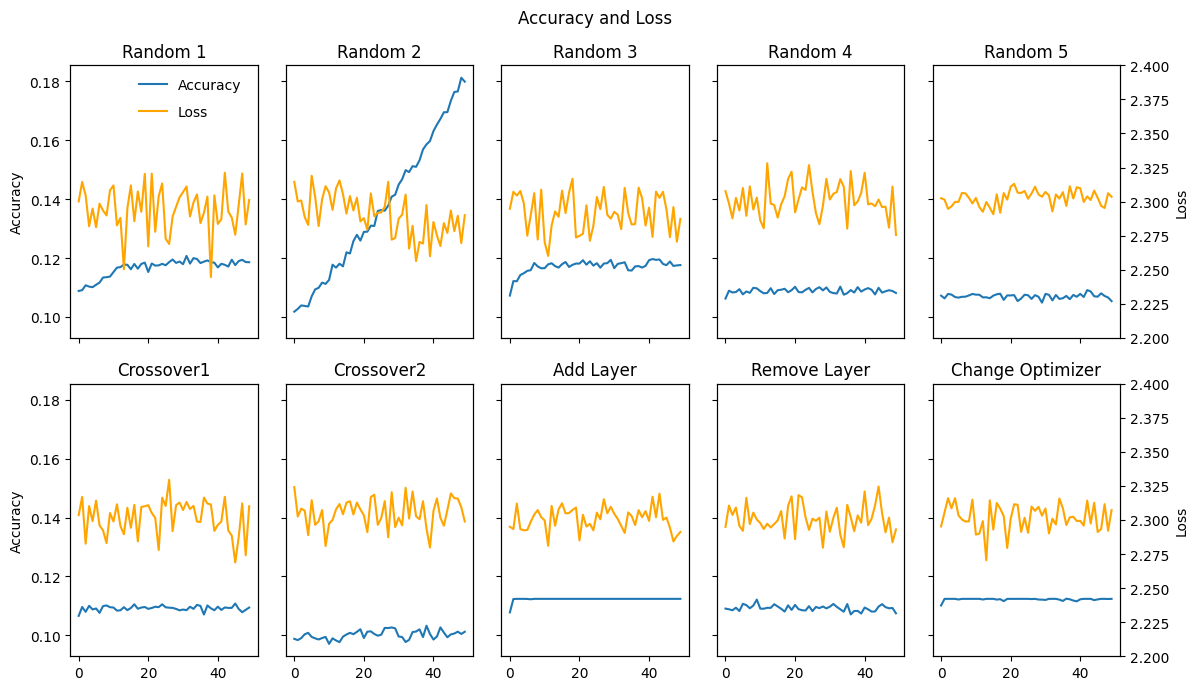

In [91]:
fig, ax = plt.subplots(2,5, figsize=(12,7), sharey=True, sharex=True, layout='tight')

for i in range(len(metrics['Accuracy'])):
    acc = metric_vals['Accuracy'][i]
    lss = metric_vals['Loss'][i]
    ax[0][i].plot(acc, label='Accuracy')
    ax[0][i].set_title(metric_vals['Labels'][i])

    ax2 = ax[0][i].twinx()
    ax2.plot(lss, label='Loss', color='orange')
    if i==0:
        ax2.legend(loc='upper left', bbox_to_anchor=(0.3, .9), frameon=False)
        ax[0][0].set_ylabel("Accuracy")
        ax[1][0].set_ylabel("Accuracy")
    

    ax2.set_ylim(min_loss, max_loss)
    if i<(len(metrics['Accuracy'])-1):
        ax2.set_yticks([])
    else:
        ax2.set_ylabel("Loss")

    # accm = [a for a in mutated_vals['Accuracy'][i]]
    # lssm = [l for l in mutated_vals['Loss'][i]]
    accm = mutated_vals['Accuracy'][i]
    lssm = mutated_vals['Loss'][i]
    ax[1][i].plot(accm, label='Accuracy')
    
    ax[1][i].set_title(mutated_vals['Labels'][i])
    
    ax2 = ax[1][i].twinx()
    ax2.plot(lssm, label='Loss', color='orange')
    ax2.set_ylim(min_loss, max_loss)
    if i<(len(metrics['Accuracy'])-1):
        ax2.set_yticks([])
    else:
        ax2.set_ylabel("Loss")
    

ax[0][0].legend(loc='upper left', bbox_to_anchor=(0.3, 1), frameon=False)

fig.suptitle("Accuracy and Loss")
plt.show()